## **Connecting with Kaggle**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
# Download Dataset - flickr-8k
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:34<00:00, 37.4MB/s]
100% 1.04G/1.04G [00:34<00:00, 32.2MB/s]


In [3]:
# Unzipping the files
import zipfile
zip_ref = zipfile.ZipFile('/content/flickr8k.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

## **Import Modules**

In [4]:
import os
import pickle
import numpy as np
from tqdm import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## **Extract Image Features**

In [5]:
# Load vgg16 model
model = VGG16()
# Restructure the model
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)
# we dont need all the layes, so to drop last layer.

553467096/553467096 [==============================] - 17s 0us/step


In [6]:
#Summarize the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# Total no of images
len(os.listdir('/content/Images'))

8091

In [8]:
# Extract features from image

directory = '/content/Images'

features = {}
for img_name in tqdm(os.listdir(directory)):
  # load the image from file
  img_path = directory + '/' + img_name
  image = load_img(img_path,target_size=(224,224))
  # convert image pixels to numpy array
  image = img_to_array(image)
  # reshape the data for model
  image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
  # pre_process image for vgg16
  image = preprocess_input(image)
  # extract features
  feature = model.predict(image,verbose=0)
  # get image_id
  image_id = img_name.split('.')[0]
  # strore features
  features[image_id] = feature

100%|██████████| 8091/8091 [08:36<00:00, 15.65it/s]


In [9]:
# store features in pickle file
pickle.dump(features,open('features.pkl','wb'))

In [10]:
# load the features from pickle
features = pickle.load(open('features.pkl','rb'))

## **Load the Captions Data**

In [11]:
# reading the captions data
with open('/content/captions.txt','r') as f:
  next(f)
  captions_doc = f.read()

In [12]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [13]:
# create mapping of image to captions

mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
  # split the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0],tokens[1:]
  # remove extention from image_id
  image_id = image_id.split('.')[0]
  # convert caption list to string
  caption = " ".join(caption)
  # create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  # store the caption
  mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 431598.72it/s]


In [14]:
len(mapping)

8091

## **Preprocess the Text Data**

In [15]:
# Cleaning the captions
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocessing steps
      caption = caption.lower() #----- convert to lower
      caption = caption.replace('[^A-Za-z]','') #---- removing digits and special char
      caption = caption.replace('\s+',' ') #----- delete additional spaces
      # add "start" and "end" tags to the captions
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i] = caption


In [16]:
# caption before preprocess
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
# preprocess the text
clean(mapping)

In [18]:
# caption after preprocess
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
# storing all the captions in the list
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [20]:
# first 5 captions
all_captions[0:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [37]:
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))

In [22]:
# Unique no of tokens
vocab_size

8485

In [23]:
# get maximum length of the caption available - usefull for padding
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [38]:
pickle.dump(max_length,open('max_length.pkl','wb'))

## **Train Test Split**

In [24]:
# 90% train & 10% test
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.9)
train = image_ids[:split]
test = image_ids[split:]

In [25]:
# startseq girl going into wooden building endseq
#            X                                     y
#        startseq                                girl
#     startseq girl                              going
#   startseq girl going                          into
# ---------------------------
# startseq girl going into wooden building      endseq

In [26]:
# to fetch the image & captions in batch size we use date generator function -- for not to crash the session/ for big dataset

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
  X1, X2, y =list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence into X, y pairs ---- pairs are shown in above cell
        for i in range(1, len(seq)):
          # split into input & output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode the output sequence (OHE)
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequence
          X1.append(features[key][0]) # ----- image features
          X2.append(in_seq) # ----------text features
          y.append(out_seq) # -----------output
      if n == batch_size:
        X1,X2,y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2],y
        X1, X2, y = list(), list(), list()
        n = 0

## **Model Creation**

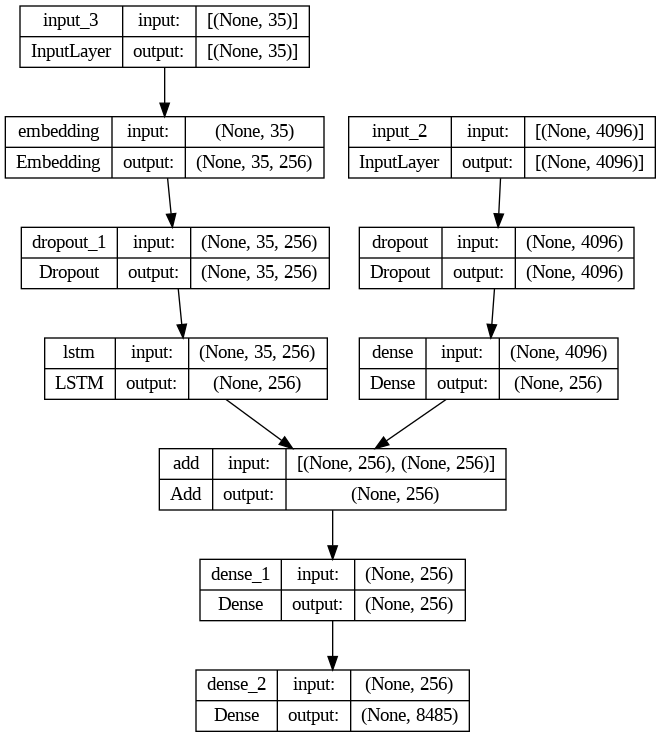

In [27]:
# Encoder Model

## image feature layers
inputs1 = Input(shape=(4096,)) #--- shape equal to vgg16 last layer shape
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
## sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [28]:
# Train the model
epochs = 50
batch_size = 64
steps = len(train)//batch_size

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for one epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 36s 318ms/step - loss: 1.8018


In [29]:
#Save the model
model.save('best_model.h5')

## **Generate Captions for the image**

In [30]:
# to covert given integer to word
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [31]:
# Generate Caption for the image
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for generation process
  in_text = 'startseq'
  # iterate over the max length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence],max_length)
    # predict next word
    yhat = model.predict([image,sequence],verbose=0)
    # get index with high probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    in_text += " " + word
    # stop if we reach end tag
    if word =='endseq':
      break
  return in_text

In [32]:
# validate with test data
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model,features[key], tokenizer, max_length)
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  # append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# calculate BLEU score
print("BLEU-1: %F" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %F" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [08:36<00:00,  1.57it/s]


BLEU-1: 0.530704
BLEU-2: 0.305078


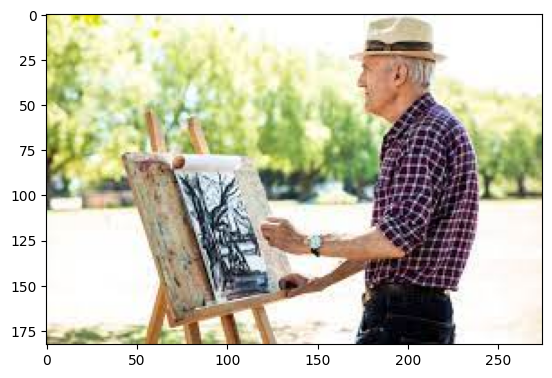

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open("/content/Demo_images/4.jpg")
plt.imshow(image)

In [34]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs,outputs=vgg_model.layers[-2].output)

In [35]:
image = load_img("/content/Demo_images/4.jpg",target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0],image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)
predict_caption(model,feature, tokenizer, max_length)

'startseq woman in hat and overalls sitting on tree branch in the background endseq'

In [36]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 35.1 MB/s eta 0:00:00


In [59]:
# Creating app file
%%writefile app.py

# importing modules
import streamlit as st
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# vgg16 model
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs,outputs=vgg_model.layers[-2].output)

# Load the model from the .h5 file
model = load_model('best_model.h5')
tokenizer = pickle.load(open('tokenizer.pkl','rb'))
max_length = pickle.load(open('max_length.pkl','rb'))

st.title('IMAGE CAPTION GENERATOR')

# Pre-process the image
def feature_extraction(img_path,vgg_model):
  image = load_img(img_path,target_size=(224,224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0],image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = vgg_model.predict(image, verbose=0)
  return feature

# Saving the uploaded images
def save_uploaded_file(uploaded_file):
  try:
    with open(os.path.join('uploads',uploaded_file.name),'wb') as f:
      f.write(uploaded_file.getbuffer())
    return 1
  except:
    return 0

# Generate Caption for the image
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for generation process
  in_text = 'startseq'
  # iterate over the max length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence],max_length)
    # predict next word
    yhat = model.predict([image,sequence],verbose=0)
    # get index with high probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    in_text += " " + word
    # stop if we reach end tag
    if word =='endseq':
      break
  return in_text

# to covert given integer to word
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None


uploaded_file = st.file_uploader("Choose an Image:")
if uploaded_file is not None:
  if save_uploaded_file(uploaded_file):
    display_image = Image.open(uploaded_file)
    st.image(display_image)

    feature = feature_extraction(os.path.join('uploads',uploaded_file.name),vgg_model)
    predicted_caption = predict_caption(model,feature, tokenizer, max_length)
    act_pred_caption = " ".join(predicted_caption.split()[1:-1])
    st.header(act_pred_caption.title())
  else:
    st.header("Some Error")

Overwriting app.py


In [60]:
!wget -q -O - ipv4.icanhazip.com

34.91.23.237


In [61]:
!streamlit run app.py & npx localtunnel --port 8501

[..................] / rollbackFailedOptional: verb npm-session be62d7df052903d


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.91.23.237:8501

npx: installed 22 in 1.578s
your url is: https://hungry-times-change.loca.lt
2023-08-22 12:13:59.577030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-22 12:14:02.257994: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
  Stopping...
^C
